In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
import re

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

## Read in payments joined on doctor_ratings table
Include doctors that are not in `doctor_ratings` table.

In [3]:
q = """SELECT payments.npi, 
                doctor_ratings.recommended_by_doctors, 
                doctor_ratings.board_certification, 
                doctor_ratings.graduation_year,
                doctor_ratings.internship_residency, 
                doctor_ratings.confidence, 
                doctor_ratings.name, 
                doctor_ratings.relative_volume,
                payments.hcpcs_code, 
                payments.hcpcs_description, 
                payments.line_srvc_cnt, 
                payments.bene_unique_cnt, 
                payments.bene_day_srvc_cnt,
                payments.average_medicare_standard_amt,
                payments.hcpcs_drug_indicator, 
                payments.nppes_provider_zip,
                payments.nppes_provider_city, 
                payments.nppes_provider_state,
                payments.place_of_service
        FROM payments
        LEFT JOIN doctor_ratings 
        ON (payments.npi = doctor_ratings.npi)
        WHERE provider_type = 'Orthopedic Surgery'"""
doctors = pd.read_sql_query(q, con=con)

In [4]:
doctors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312006 entries, 0 to 312005
Data columns (total 19 columns):
npi                              312006 non-null object
recommended_by_doctors           67029 non-null object
board_certification              67029 non-null object
graduation_year                  67029 non-null object
internship_residency             67029 non-null object
confidence                       67029 non-null float64
name                             67029 non-null object
relative_volume                  67029 non-null object
hcpcs_code                       312006 non-null object
hcpcs_description                312006 non-null object
line_srvc_cnt                    312006 non-null float64
bene_unique_cnt                  312006 non-null float64
bene_day_srvc_cnt                312006 non-null float64
average_medicare_standard_amt    312006 non-null float64
hcpcs_drug_indicator             312006 non-null object
nppes_provider_zip               312006 non-null ob

In [5]:
## convert dtypes of some columns
doctors['recommended_by_doctors'] = pd.to_numeric(doctors['recommended_by_doctors'], errors='coerce')
doctors['confidence'] = pd.to_numeric(doctors['confidence'], errors='coerce')
doctors['relative_volume'] = pd.Categorical(doctors['relative_volume'], 
                                            categories = ['Lower volume','Medium volume','Higher volume'], 
                                            ordered=True)

In [6]:
doctors.describe()

/home/cathy/miniconda3/envs/medicare_provider_util_payment/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,recommended_by_doctors,confidence,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_medicare_standard_amt
count,6171.000000,67029.000000,312006.000000,312006.000000,312006.000000,312006.000000
mean,5.875871,3.444434,128.055529,61.729861,87.273056,135.076410
std,3.120563,0.780444,393.985542,81.249665,147.037023,272.764757
min,3.000000,3.000000,11.000000,11.000000,11.000000,0.010000
25%,NaN,NaN,20.000000,17.000000,19.000000,24.220000
50%,NaN,NaN,41.000000,30.000000,37.000000,41.260000
75%,NaN,NaN,108.000000,73.000000,93.000000,82.470000
max,29.000000,5.000000,41901.000000,4517.000000,8613.000000,5870.060000


In [7]:
## Number of distinct npis (doctors) in doctors dataframe
doctors.drop_duplicates(['npi']).shape

(20652, 19)

In [8]:
(doctors.drop_duplicates(['npi']).
         query('~confidence.isnull()').
         query('confidence > 0')['confidence'].value_counts())

3.0    2591
5.0     646
4.0     298
Name: confidence, dtype: int64

## Counts per code

In [9]:
## How many distinct hcpcs codes are there in the dataset?
doctors['hcpcs_code'].drop_duplicates().size

1391

In [10]:
## How many distinct hcpcs codes are there in the dataset among
## doctors found in doctor_ratings?
doctors.loc[~doctors.confidence.isnull(),'hcpcs_code'].drop_duplicates().size

630

In [11]:
## Narrow down rows to only place of service = 'F' (facility).
## quick check that there are no duplicate rows for a specific (npi, hcpcs_code, place_of_service)
(doctors.query('place_of_service == "F"').
         groupby(['npi','hcpcs_code'])['npi'].
         count().
         reset_index(name='count').
         query('count>1')).shape

(0, 3)

In [12]:
# How many times does each code occur (as a row) in the table?
## only count place_of_service occuring in a facility.
## (doctors can have more than 1 claim per hcpcs_code due to different place_of_service)
counts_per_code = (doctors.query('place_of_service == "F"').
                           groupby('hcpcs_code').
                           count()['npi'].
                           reset_index(name='count'))
counts_per_code.head()

,hcpcs_code,count
0,0054T,1
1,0055T,2
2,0171T,3
3,0275T,2
4,10140,1


In [13]:
pd.set_option('max_colwidth', 80)
counts_per_code = (counts_per_code.merge(doctors[['hcpcs_code', 'hcpcs_description','hcpcs_drug_indicator']].
                                         drop_duplicates('hcpcs_code'),
                                         on='hcpcs_code')
                                   .sort_values('count', ascending=False))
counts_per_code.head(20)

## note, top claimed hcpcs_code for doctors in doctor_ratings buset is 20610, i.e.
## (Aspiration and/or injection of large joint or joint capsule)

,hcpcs_code,count,hcpcs_description,hcpcs_drug_indicator
348,27447,6819,Repair of knee joint,N
291,27130,3959,Replacement of thigh bone and hip joint prosthesis,N
810,99222,3712,"Initial hospital inpatient care, typically 50 minutes per day",N
809,99221,2621,"Initial hospital inpatient care, typically 30 minutes per day",N
811,99223,2608,"Initial hospital inpatient care, typically 70 minutes per day",N
802,99213,2375,"Established patient office or other outpatient visit, typically 15 minutes",N
492,29826,2302,Shaving of shoulder bone using an endoscope,N
309,27245,2157,Surgical treatment of broken thigh bone,N
72,20610,2060,Aspiration and/or injection of large joint or joint capsule,N
797,99203,1805,"New patient office or other outpatient visit, typically 30 minutes",N


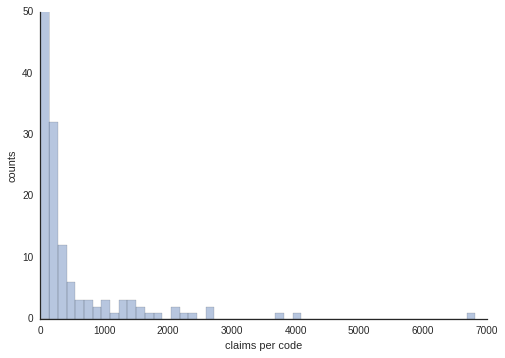

In [14]:
g = sns.distplot(counts_per_code['count'], kde=False)
g.set(ylim=(0,50), xlabel='claims per code', ylabel='counts')
sns.despine()

## Describe each doctor by a feature vector of beneficiary/per day service counts

In [15]:
by_npi = (doctors.query('place_of_service == "F"')[['npi','hcpcs_code','bene_day_srvc_cnt']].
                pivot(index='npi', values = 'bene_day_srvc_cnt', columns='hcpcs_code').
                fillna(value=0))

by_npi.head(4)

hcpcs_code,0054T,0055T,0171T,0275T,10140,10180,11011,11012,11042,11043,...,G0414,G0416,G0438,G0439,G0453,G0461,G0462,J1030,J1100,J3301
npi,,,,,,,,,,,,,,,,,,,,,
1003002890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003010919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003012493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003013947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


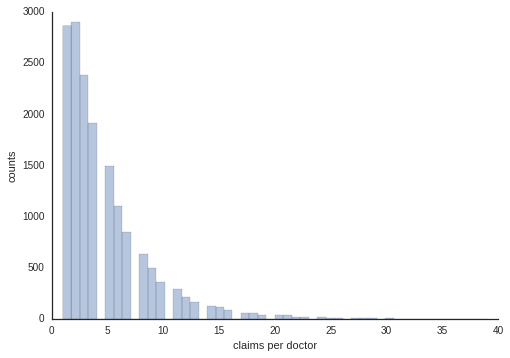

In [16]:
## How many different codes have been claimed per doctor?  Plot distribution
## TO DO: plot distribution of doctors only in doctor_ratings. (looks different?)

number_of_different_drug_codes_per_doctor = (by_npi > 0.0).sum(axis = 1)
g = sns.distplot(number_of_different_drug_codes_per_doctor, kde=False)
g.set(xlabel='claims per doctor', ylabel='counts')
sns.despine()

In [17]:
## How many columns have only 1 non-zero observation?
observations_per_col = by_npi.astype(bool).sum(axis=0)
sum(observations_per_col == 1)

279

In [61]:
cols_to_drop = by_npi.columns.values[np.nonzero(observations_per_col == 1)]
cols_to_drop.shape

(279,)

In [62]:
by_npi_reduced = by_npi.drop(cols_to_drop, axis=1)
by_npi_reduced.head()

hcpcs_code,0055T,0171T,0275T,10180,11012,11042,11043,11044,11045,11047,...,G0179,G0180,G0289,G0413,G0453,G0461,G0462,J1030,J1100,J3301
npi,,,,,,,,,,,,,,,,,,,,,
1003002890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003010919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003012493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003013947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003016718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
## normalize columns of by_npi_reduced
from sklearn import preprocessing
X_raw = by_npi_reduced.as_matrix()
X_normed = preprocessing.scale(X_raw)

## Distribution of low/high/volume patient doctors

In [22]:
doctors.query('~relative_volume.isnull()').drop_duplicates('npi')['relative_volume'].value_counts()

Higher volume    1824
Medium volume    1232
Lower volume      478
Name: relative_volume, dtype: int64

In [23]:
(doctors.query('~relative_volume.isnull()').
         drop_duplicates('npi')[['confidence', 'relative_volume']].
         groupby(['confidence','relative_volume'])['relative_volume'].
         count())

confidence  relative_volume
3.0         Lower volume        421
            Medium volume      1042
            Higher volume      1127
4.0         Lower volume         35
            Medium volume        95
            Higher volume       168
5.0         Lower volume         22
            Medium volume        95
            Higher volume       529
Name: relative_volume, dtype: int64

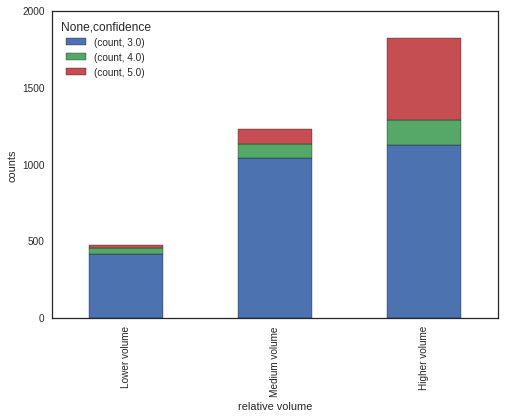

In [24]:
myplot = ((pd.DataFrame(doctors.query('~relative_volume.isnull()').
         drop_duplicates('npi')[['confidence', 'relative_volume']].
         groupby(['confidence','relative_volume'])['relative_volume'].
         count()).
         rename(columns={'relative_volume':'count'}).
         reset_index()).
         pivot('relative_volume','confidence').
         plot(kind='bar', stacked=True))
myplot.set(xlabel = 'relative volume', ylabel='counts')

In [39]:
## make color codes 
## is doctor labeled good doctor by surgeonratings? (1 if yes, 0 if no)
## confidence, relative_volume, years since graduation, recommended by doctors, board_certification (y/n)
color_codes = (pd.DataFrame({'npi':by_npi_reduced.index}).
               merge(doctors.drop_duplicates(['npi'])[['npi','confidence']]).
               fillna(0))
color_codes.loc[color_codes.confidence!=0.0, 'confidence'] = 1.0
color_codes.head()

,npi,confidence
0,1003002890,0.0
1,1003010919,0.0
2,1003012493,0.0
3,1003013947,0.0
4,1003016718,0.0


In [30]:
## for each column, are there any NAs?
color_codes.apply(lambda x: x.isnull().any(), axis=0)

npi                       False
confidence                 True
relative_volume            True
recommended_by_doctors     True
graduation_year            True
board_certification        True
dtype: bool

In [31]:
## How many rows are missing graduation_year?
color_codes['graduation_year'].map(lambda x: x=='').sum()

156

In [63]:
## process color codes
color_codes['board_certification'] = (color_codes['board_certification'].
                                      map(lambda x: x != '')) # board-certified => True
#color_codes = (color_codes.
               #assign(yrs_since_graduation = lambda x: (2014 - int(x.graduation_year)) if x.graduation_year != '' else np.NaN).
#               assign(is_recommended = lambda x: True if np.isnan(x.recommended_by_doctors) else False))
color_codes.head()

,npi,confidence,relative_volume,recommended_by_doctors,graduation_year,board_certification
0,1003029034,3,Medium volume,NaN,2004,True
1,1003802646,3,Medium volume,NaN,,True
2,1003808098,3,Medium volume,NaN,1981,True
3,1003809484,5,Higher volume,NaN,1997,True
4,1003811514,3,Lower volume,NaN,1978,True


In [65]:
## board certified?
color_codes['board_certification'].value_counts()

True     3111
False     424
Name: board_certification, dtype: int64

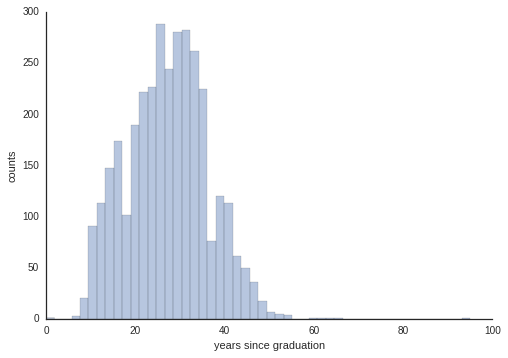

In [54]:
graduation_yr_missing = (color_codes['graduation_year'] == '')
yrs_since_graduation = (color_codes.loc[~graduation_yr_missing, 
                                      'graduation_year'].
                        astype(int).map(lambda x: 2014 - x))
g = sns.distplot(yrs_since_graduation, kde=False)
g.set(xlabel='years since graduation', ylabel='counts')
sns.despine()

In [152]:
yrs_since_graduation.describe()
## the maximum years since graduation seems impossible

count    3363.000000
mean       27.250372
std         9.079187
min         0.000000
25%        21.000000
50%        27.000000
75%        34.000000
max        95.000000
Name: graduation_year, dtype: float64

## tSNE of doctors in medicare claims space

In [64]:
## tsne on smaller feature space (dropped cols with only 1 observation)
## 279 columns
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_raw)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 16320
[t-SNE] Computed conditional probabilities for sample 2000 / 16320
[t-SNE] Computed conditional probabilities for sample 3000 / 16320
[t-SNE] Computed conditional probabilities for sample 4000 / 16320
[t-SNE] Computed conditional probabilities for sample 5000 / 16320
[t-SNE] Computed conditional probabilities for sample 6000 / 16320
[t-SNE] Computed conditional probabilities for sample 7000 / 16320
[t-SNE] Computed conditional probabilities for sample 8000 / 16320
[t-SNE] Computed conditional probabilities for sample 9000 / 16320
[t-SNE] Computed conditional probabilities for sample 10000 / 16320
[t-SNE] Computed conditional probabilities for sample 11000 / 16320
[t-SNE] Computed conditional probabilities for sample 12000 / 16320
[t-SNE] Computed conditional probabilities for sample 13000 / 16320
[t-SNE] Computed conditional probabilities

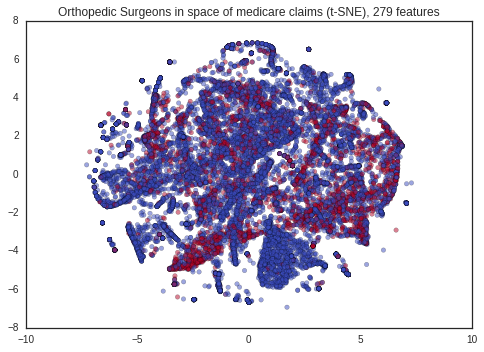

In [70]:
sc = plt.scatter(X_embedded[:,0], X_embedded[:,1], 
                 c=color_codes['confidence'], cmap='coolwarm', alpha=0.5)
plt.title('Orthopedic Surgeons in space of medicare claims (t-SNE), 279 features')

In [67]:
X_embedded_normed = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_normed)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 16320
[t-SNE] Computed conditional probabilities for sample 2000 / 16320
[t-SNE] Computed conditional probabilities for sample 3000 / 16320
[t-SNE] Computed conditional probabilities for sample 4000 / 16320
[t-SNE] Computed conditional probabilities for sample 5000 / 16320
[t-SNE] Computed conditional probabilities for sample 6000 / 16320
[t-SNE] Computed conditional probabilities for sample 7000 / 16320
[t-SNE] Computed conditional probabilities for sample 8000 / 16320
[t-SNE] Computed conditional probabilities for sample 9000 / 16320
[t-SNE] Computed conditional probabilities for sample 10000 / 16320
[t-SNE] Computed conditional probabilities for sample 11000 / 16320
[t-SNE] Computed conditional probabilities for sample 12000 / 16320
[t-SNE] Computed conditional probabilities for sample 13000 / 16320
[t-SNE] Computed conditional probabilities

In [155]:
## len(yrs_since_graduation) != len(X_embedded)

#sc = plt.scatter(X_embedded[~graduation_yr_missing,0], 
#                 X_embedded[~graduation_yr_missing,1], 
#                 c = yrs_since_graduation, cmap='YlOrRd')

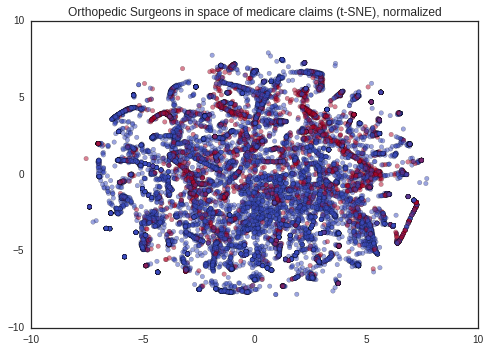

In [71]:
sc = plt.scatter(X_embedded_normed[:,0], X_embedded_normed[:,1], 
                 c=color_codes['confidence'], cmap='coolwarm', alpha=0.5)
plt.title('Orthopedic Surgeons in space of medicare claims (t-SNE), normalized')

## PCA plots on normalized data

In [42]:
from sklearn import decomposition

In [72]:
## use reduced space (279 columns)
pca = decomposition.PCA(n_components=3)
pca.fit(X_normed)

PCA(copy=True, n_components=3, whiten=False)

In [73]:
pca.explained_variance_ratio_

array([ 0.0191623 ,  0.01264379,  0.01243567])

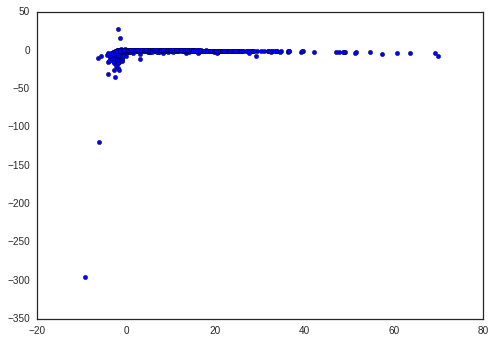

In [74]:
X_pca = pca.transform(X_normed)
plt.scatter(X_pca[:,0], X_pca[:,1])

In [75]:
## locate the index of the largest absolute value in principle component 2
max_element_pc1 = np.argmax(np.absolute(pca.components_[1]))
max_element_pc1

215

In [76]:
## which hcpcs_code does 215 correspond to?
by_npi_reduced.columns.values[215]

'27301'

In [77]:
## only 1 doctor made a claim compared to all other claims
## => largest axis of variation
doctors[doctors.hcpcs_code == '27301']

,npi,recommended_by_doctors,board_certification,graduation_year,internship_residency,confidence,name,relative_volume,hcpcs_code,hcpcs_description,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_medicare_standard_amt,hcpcs_drug_indicator,nppes_provider_zip,nppes_provider_city,nppes_provider_state,place_of_service
27219,1083696074,NaN,None,None,None,NaN,None,NaN,27301,Drainage of abscess or blood collection at thigh or knee region,13.0,12.0,13.0,276.70,N,912064071,GLENDALE,CA,F
42104,1134146855,NaN,None,None,None,NaN,None,NaN,27301,Drainage of abscess or blood collection at thigh or knee region,57.0,56.0,57.0,200.58,N,344717847,OCALA,FL,F
89010,1285625384,NaN,Orthopaedic Sports Medicine; Orthopaedic Surgery,1992,,3.0,"Yacoubian, Stephan Vahe",Medium volume,27301,Drainage of abscess or blood collection at thigh or knee region,34.0,34.0,34.0,203.67,N,915054806,BURBANK,CA,F
255810,1821053562,NaN,None,None,None,NaN,None,NaN,27301,Drainage of abscess or blood collection at thigh or knee region,24.0,23.0,24.0,230.83,N,344717847,OCALA,FL,F


## k-means clustering 

In [ ]:
## tSNE plots color coded according to physician level characteristics

plt.rcParams['figure.figsize'] = (15.0, 15.0)

## color code values to run through
color_col_idx = list(range(1,5))+[7]
#color_col_idx = list(range(1,5))

for i, color_idx in enumerate(color_col_idx):
    plt.subplot(3,2, i+1)
    sc = plt.scatter(X_embedded[:,0], X_embedded[:,1], 
                     c=np.log(color_codes.iloc[:, color_idx] + 1.0), cmap='YlOrRd')
    plt.colorbar(sc)
    plt.title(color_codes.columns.values[color_idx])

In [78]:
if con:
    con.close()